In [3]:
import numpy as np
import csv
import glob
import os.path
from os import path
from datetime import datetime
import matplotlib.pyplot as plt

In [4]:
import talib

In [5]:
# The basic CSV instrument. We'll abstract this later when we need it
class FileInstrument:
    def __init__(self, filename, load=True):
        self.datetime_format = '%d-%b-%Y'
        self.column_names = ['day', 'month', 'year', 'open', 'high', 'low', 'close', 'volume', 'forward_returns']
        self.column_set = set(self.column_names)
        
        self.data = None
        
        if load:
            self.load_file(filename)
        
    def load_file(self, filename):
        with open(filename) as f:
            item = []
            reader = csv.reader(f)
            for row in reader:
                _row = self.format_row(*row)
                item.append(_row)
                
        item = np.array(item)
        returns = np.expand_dims(np.diff(item[:,-2], append=item[:,-2][-1]), axis=1)
        
        items_with_returns = np.hstack((item, returns))
        self.data = items_with_returns
        
    def format_row(self, *args):
        date = datetime.strptime(args[0], self.datetime_format)
        o = float(args[1])
        h = float(args[2])
        l = float(args[3])
        c = float(args[4])
        v = int(args[5])

        return [date.day, date.month, date.year, o, h, l, c, v]
    
    def attach_feature(self, feature, name):
        self.column_set.add(name) # this will fail if the feature already exists
        self.column_names.append(name)
        
        f = np.expand_dims(feature, axis=1)
        self.data = np.hstack((self.data, f))
    
    def __getitem__(self, key):
        if type(key) == str:
            idx = self.column_names.index(key)
            return self.data[:,idx]
        
        return self.data.__getitem__(key)

    def __repr__(self):
        return self.data.__repr__()

In [6]:
luv = FileInstrument('../../../Developer/Data/prices/FOREX/EURUSD.csv')

In [7]:
d = np.diff(luv['close'], prepend=luv['close'][0])

In [8]:
luv.attach_feature(d, 'back_returns')

In [9]:
luv['back_returns']

array([ 0.    ,  0.0034, -0.0051, ...,  0.001 ,  0.0019,  0.0018])

In [10]:
def run_monte_single(asset, idx, samples=1000, simulations=1000):
    returns = asset['forward_returns'][idx]
    mcs = np.stack([np.cumsum(np.random.choice(returns, samples)) for i in range(simulations)])
    return mcs

In [11]:
mc = run_monte_single(luv, luv['close'] > talib.EMA(luv['close'], timeperiod=100), samples=50000)

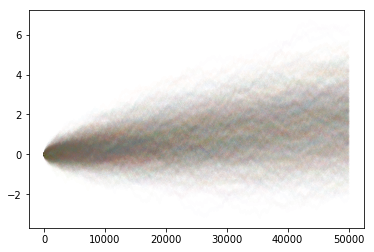

In [12]:
plt.plot(mc.T, alpha=0.01)

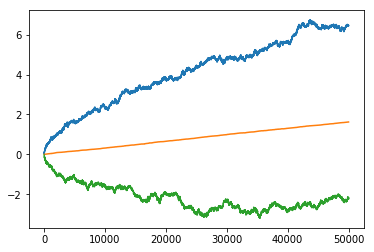

In [13]:
plt.plot(np.max(mc, axis=0))
plt.plot(np.mean(mc, axis=0))
plt.plot(np.min(mc, axis=0))

In [14]:
aapl = FileInstrument('../../../Developer/Data/prices/NASDAQ/AAPL.csv')

In [15]:
d = np.diff(aapl['close'], prepend=aapl['close'][0])
aapl.attach_feature(d, 'back_returns')

In [16]:
mc = run_monte_single(aapl, aapl['back_returns'] > talib.EMA(aapl['back_returns'], timeperiod=100))

In [17]:
vanilla = run_monte_single(aapl, np.random.choice([True, False], size=len(aapl[:,0]), p=[1, 0]))

(array([ 3.,  1.,  1.,  3.,  5.,  5.,  8., 10.,  5., 13., 20., 19., 19.,
        21., 21., 30., 34., 38., 38., 38., 34., 36., 51., 50., 46., 48.,
        42., 44., 40., 30., 28., 41., 32., 35., 25., 19., 13., 10.,  8.,
         8.,  6.,  5.,  9.,  2.,  2.,  2.,  0.,  1.,  0.,  1.]),
 array([-32.8861  , -27.884656, -22.883212, -17.881768, -12.880324,
         -7.87888 ,  -2.877436,   2.124008,   7.125452,  12.126896,
         17.12834 ,  22.129784,  27.131228,  32.132672,  37.134116,
         42.13556 ,  47.137004,  52.138448,  57.139892,  62.141336,
         67.14278 ,  72.144224,  77.145668,  82.147112,  87.148556,
         92.15    ,  97.151444, 102.152888, 107.154332, 112.155776,
        117.15722 , 122.158664, 127.160108, 132.161552, 137.162996,
        142.16444 , 147.165884, 152.167328, 157.168772, 162.170216,
        167.17166 , 172.173104, 177.174548, 182.175992, 187.177436,
        192.17888 , 197.180324, 202.181768, 207.183212, 212.184656,
        217.1861  ]),
 <a list of 50

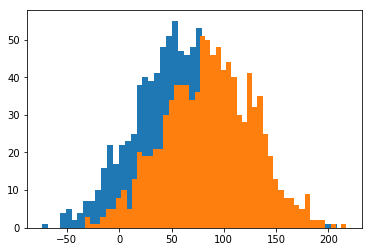

In [18]:
plt.hist(vanilla[:,-1], bins=50)
plt.hist(mc[:,-1], bins=50)

In [19]:
strat = aapl['close'] > talib.EMA(aapl['close'], timeperiod=100)

In [20]:
performance = strat.astype(int) * aapl['forward_returns']

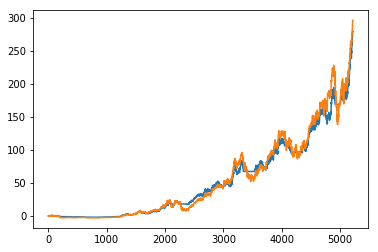

In [21]:
plt.plot(np.cumsum(performance))
plt.plot(np.cumsum(aapl['forward_returns']))

In [22]:
time_in_market = np.sum(strat.astype(int)) / len(strat)

In [23]:
strat_perf = np.cumsum(performance)
buy_hold_perf = np.cumsum(aapl['forward_returns'])

In [24]:
strat_v_bh = strat_perf[-1] / buy_hold_perf[-1]

In [25]:
print(f'Time in the market: \t\t{time_in_market*100:.2f}%')
print(f'Performance against BH: \t{strat_v_bh*100:.2f}%')
print(f'Volatility efficiency: \t\t{(strat_v_bh / time_in_market)*100:.2f}%')

Time in the market: 		68.75%
Performance against BH: 	94.38%
Volatility efficiency: 		137.28%


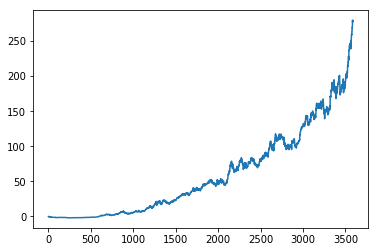

In [26]:
plt.plot(np.cumsum(aapl['forward_returns'][strat]))

In [27]:
from statsmodels.stats.weightstats import ttest_ind

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [28]:
ttest_ind(mc[:,-1], vanilla[:,-1])

(14.191631625459893, 1.2620504460123113e-43, 1998.0)

In [29]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.997):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [30]:
mean_confidence_interval(mc[:,-1])

(86.24743899999996, 82.23789779090443, 90.25698020909549)

In [31]:
mean_confidence_interval(vanilla[:,-1])

(58.89894170000001, 54.801058583385974, 62.996824816614044)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe19e84e978>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe19e84efd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe19e84e828>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe19e85b6a0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe19e85b9e8>,
 'means': []}

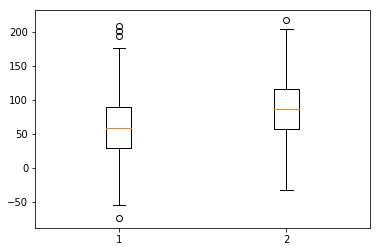

In [32]:
plt.boxplot((vanilla[:,-1], mc[:,-1]))

In [33]:
scipy.stats.ttest_ind(mc[:,-1], vanilla[:,-1])

Ttest_indResult(statistic=14.191631625459912, pvalue=1.262050446012005e-43)

(array([1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 7.000e+00,
        9.000e+00, 8.000e+00, 7.000e+00, 1.800e+01, 2.600e+01, 4.000e+01,
        4.900e+01, 7.700e+01, 1.340e+02, 3.060e+02, 8.660e+02, 2.544e+03,
        4.900e+02, 2.550e+02, 1.280e+02, 7.000e+01, 5.400e+01, 3.300e+01,
        1.800e+01, 1.800e+01, 7.000e+00, 8.000e+00, 1.400e+01, 4.000e+00,
        6.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00]),
 array([-15.73  , -15.1912, -14.6524, -14.1136, -13.5748, -13.036 ,
        -12.4972, -11.9584, -11.4196, -10.8808, -10.342 ,  -9.8032,
         -9.2644,  -8.7256,  -8.1868,  -7.648 ,  -7.1092,  -6.5704,
         -6.0316,  -5.4928,  -4.954 ,  -4.4152,  -3.8764,  -3.3376,
         -2.7988,  -2.26  ,  -1.7212,  -1.1824,  -0.6436,  -0.1048,
          0.434 ,   0.9728,   1.5116

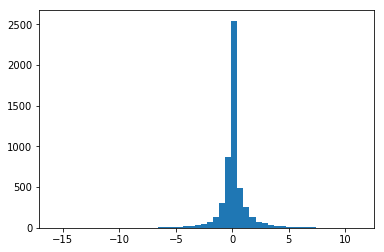

In [34]:
plt.hist(aapl['forward_returns'], bins=50)

In [1]:
mc = run_monte_single(aapl, aapl['back_returns'] > talib.EMA(aapl['back_returns'], timeperiod=100))
vanilla = run_monte_single(aapl, np.random.choice([True, False], size=len(aapl[:,0]), p=[1, 0]))

NameError: name 'aapl' is not defined